In [12]:
import numpy as np 
np.set_printoptions(precision=4)
from scipy.stats import multivariate_normal as mvn
from tqdm import tqdm
from scipy.special import j1
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 3
mpl.rcParams['axes.titlesize'] = 20
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.titlepad'] = 8.0
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 3
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 3
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams['lines.markersize'] = 5
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['legend.fontsize'] = 15

In [13]:
# Define the target distribution
mean1 = np.array([0.35, 0.38])
cov1 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w1 = 0.6

mean2 = np.array([0.68, 0.25])
cov2 = np.array([
    [0.005, -0.003],
    [-0.003, 0.005]
])
w2 = 0.2

mean3 = np.array([0.56, 0.64])
cov3 = np.array([
    [0.008, 0.0],
    [0.0, 0.004]
])

w3 = 0.1

mean4 = np.array([0.22, 0.74])
cov4 = np.array([
    [0.01, 0.004],
    [0.004, 0.01]
])
w4 = 0.1

def pdf(x):
    return w1 * mvn.pdf(x, mean1, cov1) + \
           w2 * mvn.pdf(x, mean2, cov2) + \
           w3 * mvn.pdf(x, mean3, cov3) + \
           w4 * mvn.pdf(x, mean4, cov4)
# Define a 1-by-1 2D search space
L_list = np.array([1.0, 1.0])  # boundaries for each dimension

# Discretize the search space into 100-by-100 mesh grids
num_grid = 100
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], num_grid),
    np.linspace(0, L_list[1], num_grid)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = 1.0 / (num_grid - 1)
dy = 1.0 / (num_grid - 1)

In [14]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [15]:
# Configure the index vectors
num_k_per_dim = 50
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T
# Pre-processing lambda_k and h_k
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0) # Fourier
hk_list = np.zeros(ks.shape[0])

#Normalization Constant Fourier
# For gaussian sensor distribution Makes Cov = diag(var_1, var_2)
for i, k_vec in enumerate(ks):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)
    hk_list[i] = hk
# compute the coefficients for the target distribution Fourier
phik_list = np.zeros(ks.shape[0])  
pdf_vals = pdf(grids)
for i, (k_vec, hk) in enumerate(zip(ks, hk_list)):
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)  
    fk_vals /= hk
    phik = np.sum(fk_vals * pdf_vals) * dx * dy 
    phik_list[i] = phik

In [16]:
from scipy.spatial.distance import cdist
from numpy.linalg import solve
def safe_log_div(p, q):
    """Compute p * log(p / q) safely."""
    mask = (p > 0) & (q > 0)
    return np.sum(p[mask] * np.log(p[mask] / q[mask]))

def compare_pdfs(pdf1, pdf2, epsilon=1e-12):
    # Flatten and add epsilon
    p = pdf1.ravel().astype(float) + epsilon
    q = pdf2.ravel().astype(float) + epsilon ## empirical one

    # Normalize to sum to 1
    p /= np.sum(p)
    q /= np.sum(q)
    m = 0.5 * (p + q)

    results = {
        "L2 distance": np.linalg.norm(p - q),
        "Total Variation": 0.5 * np.sum(np.abs(p - q)),
        "KL(p || q)": safe_log_div(p, q),
        "KL(q || p)": safe_log_div(q, p),
        "Jensen-Shannon": 0.5 * (safe_log_div(p, m) + safe_log_div(q, m)),
        "Cosine similarity": np.dot(p, q) / (np.linalg.norm(p) * np.linalg.norm(q))
    }

    return results

def reconstruct_fourier(coeffs, hk_list, ks, grids):
    phi_recon = np.zeros(grids.shape[0])
    for i, (k_vec, ck, hk) in enumerate(zip(ks, coeffs, hk_list)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        fk_vals /= hk
        phi_recon += ck * fk_vals
    return phi_recon

def reconstruct_radial_basis(coeffs, weights, sigmas, centers, grids):
    M = centers.shape[0]
    N = sigmas.shape[0]
    d = centers.shape[1]
    pairwise_centers = cdist(centers, centers, 'sqeuclidean')  # shape (M, M)
    G = np.zeros((M, M))
    for i in range(N):
        for m in range(N):
            coef = (np.sqrt(np.pi) * np.sqrt(2 * sigmas[i]**2 * sigmas[m]**2 / (sigmas[i]**2 + sigmas[m]**2)))**d
            exp_term = np.exp(-pairwise_centers / (2 * (sigmas[i]**2 + sigmas[m]**2)))
            G += weights[i] * weights[m] * coef * exp_term
    rhs = np.zeros(M)
    for i in range(N):
        coef = (np.sqrt(np.pi) * np.sqrt(2) * sigmas[i])**d
        rhs += weights[i] * coef * coeffs
    c = np.linalg.solve(G + 1e-6 * np.eye(M), rhs)
    
    sq_dists = cdist(grids, centers, 'sqeuclidean')
    rbf_vals = np.zeros((grids.shape[0], M))
    for i in range(N):
        rbf_vals += weights[i] * np.exp(-sq_dists / (2 * sigmas[i]**2))
    
    phi_recon = rbf_vals @ c
    return phi_recon

def reconstruct_Indicator(coeffs):
    fks = np.zeros((grids.shape[0], len(ks)))
    for i,_ in enumerate(ks):
        f1 = sig(grids,lower[i])
        f2 = sig(grids,upper[i])
        fks[:, i] = np.prod(f1 * (1 - f2), axis=-1)

    # Compute Gram matrix and RHS vector
    G = fks.T @ (fks * dx * dy)
    # Solve for coefficients
    c = np.linalg.solve(G + 1e-6 * np.eye(G.shape[0]), coeffs)
    phi_recon = fks @ c
    return phi_recon
    
    

In [17]:
def barrier_and_grad(x, y, L, epsilon=1e-4):
    def soft_repel(s, Ls):
        return 1 / (s + epsilon) + 1 / (Ls - s + epsilon)
    
    def grad_soft_repel(s, Ls):
        return -1 / (s + epsilon)**2 + 1 / (Ls - s + epsilon)**2

    B = soft_repel(x, L[0]) + soft_repel(y, L[1])
    dBx = grad_soft_repel(x, L[0])
    dBy = grad_soft_repel(y, L[1])
    return B, np.array([dBx, dBy])

In [18]:
def coeffs_to_psd_matrix(c):
    n = len(c)
    T = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            k = (i - j) % n
            T[i, j] = c[k]
    return (T + T.T) / 2

def psd_matrix_to_coeffs(T):
    n = T.shape[0]
    c = np.zeros(n)
    for k in range(n):
        vals = [T[i, (i - k) % n] for i in range(n)]
        c[k] = np.mean(vals)
    return c

def update_phik_list_expanded(phik_list_expanded, ck_list_update, phik_list, alpha):
    N_agents = phik_list_expanded.shape[1]
    T_c_list = [coeffs_to_psd_matrix(phik_list_expanded[:, i]) for i in range(N_agents)]
    T_b_list = [coeffs_to_psd_matrix(ck_list_update[:, i]) for i in range(N_agents)]
    T_b_sum = sum(T_b_list)
    T_a = coeffs_to_psd_matrix(phik_list)
    T_b_sum_inv = np.linalg.pinv(T_b_sum)
    T_tilde_list = [T_b_i @ T_b_sum_inv @ T_a for T_b_i in T_b_list]
    T_c_new_list = [(1 - alpha) * T_c_i + alpha * T_tilde_i for T_c_i, T_tilde_i in zip(T_c_list, T_tilde_list)]
    phik_list_expanded_new = np.column_stack([psd_matrix_to_coeffs(T_c_new) for T_c_new in T_c_new_list])
    return phik_list_expanded_new


In [19]:
# Specify the dynamic system 
N_agents = 3
dt = 0.01
tsteps = 10001
ud = 0.2  # desired velocity 0.2 m/s
results_fourier = []

def dyn(xt, ut):
    xdot = ut 
    return ut

def step(xt, ut):
    xt_new = xt + dt * dyn(xt, ut)
    return xt_new 

phik_list *= N_agents
phik_list_expanded = np.repeat(phik_list[:, None], N_agents, axis=1) / N_agents
# start SMC iteration
xt = np.random.uniform(low=0.2, high=0.8, size=(2,N_agents)) # inital state
#xt = np.array([0.5,0.5]) # for fair comparison!
x_traj = np.zeros((tsteps, 2, N_agents)) # trajectory
ck_list_update = np.zeros((ks.shape[0], N_agents))  # trajectory coefficients (update over time, not normalized)
cK_lists = []
metric_log = []  # record ergodic metric at each step
timeit = []

for t in range(tsteps):

    fk_xt_all = np.prod(np.cos(np.pi * ks[:, :, None] / L_list[None, :, None] * xt[None, :, :]), axis=1) / hk_list[:, None]
    
    ck_list_update += fk_xt_all * dt

    # step 3: compute the derivative of all basis functions at the current state
    ## Radial basis multiple sigmas


    dfk_xt_all = np.array([
        -np.pi * ks[:, 0, None] / L_list[0] * np.sin(np.pi * ks[:, 0, None] / L_list[0] * xt[0, None, :]) * np.cos(np.pi * ks[:, 1, None] / L_list[1] * xt[1, None, :]),
        -np.pi * ks[:, 1, None] / L_list[1] * np.cos(np.pi * ks[:, 0, None] / L_list[0] * xt[0, None, :]) * np.sin(np.pi * ks[:, 1, None] / L_list[1] * xt[1, None, :]),
    ]) / hk_list[:, None]
    
    # step 4: compute control signal
    print(ck_list_update.shape, phik_list.shape, dfk_xt_all.shape, lamk_list.shape)
    S = lamk_list * (np.sum(ck_list_update / (t*dt + dt), axis = -1) - phik_list)
    bt = np.sum(S[None, :, None] * dfk_xt_all, axis=1)
    ut = -ud * bt / (np.linalg.norm(bt, axis=0) + 1e-8)
    # step 5: execute the control, move on to the next iteration
    xt = step(xt, ut)
    ## Update individual measures
    x_traj[t] = xt.copy()
    erg_metric = np.sum(np.square(np.sum(ck_list_update / (t*dt + dt), axis = -1) - phik_list))
    metric_log.append(erg_metric)
    if t % 1000 == 0:     
        print(f"Step {t}, Position: {xt[:2,0]}, Metric: {erg_metric:.5f}")  

(2500, 3) (2500,) (2, 2500, 3) (2500,)
Step 0, Position: [0.5434 0.2317], Metric: 7111.87607
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) (2500,) (2, 2500, 3) (2500,)
(2500, 3) 

KeyboardInterrupt: 

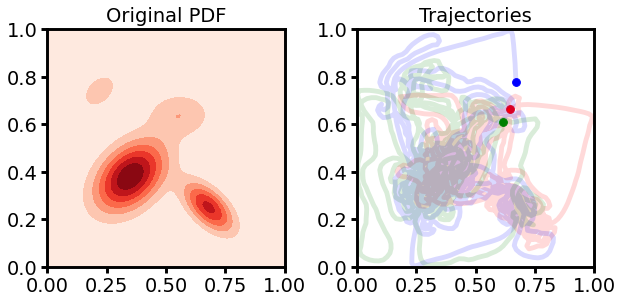

In [ ]:
import matplotlib.cm as cm
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
#fig, axes = plt.subplots(figsize=(6, 4), dpi=100, tight_layout=True) #### For now only one plot as i do not wish to reconstruct.
ax = axes[0]
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title('Original PDF')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds')
distinct_colors = [
    'red', 'blue', 'green', 'orange', 'purple',
    'cyan', 'magenta', 'brown', 'olive', 'black',
    'pink', 'teal', 'navy', 'gold', 'lime',
    'coral', 'indigo', 'turquoise', 'maroon', 'gray'
]
ax = axes[1]
ax.set_title('Trajectories')
ax.set_aspect('equal')
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
for i in range(N_agents):
    color = distinct_colors[i % len(distinct_colors)]
    ax.plot(x_traj[::10, 0, i], x_traj[::10, 1, i], linestyle='-', marker='', color=color, alpha=0.15, label=f'Trajectory {i}')
    ax.plot(x_traj[0, 0, i], x_traj[0, 1, i], linestyle='', marker='o', markersize=8, color=color, alpha=1.0, label=f'Init {i}')
#ax.legend(loc=1)

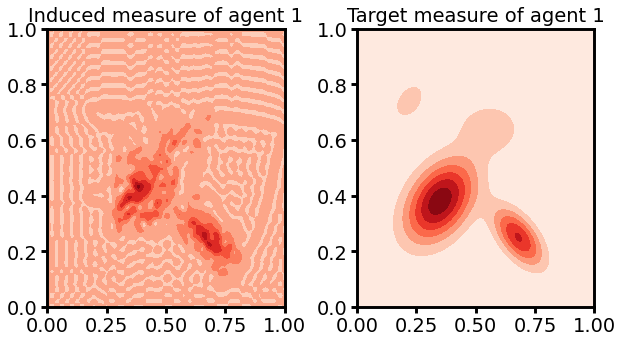

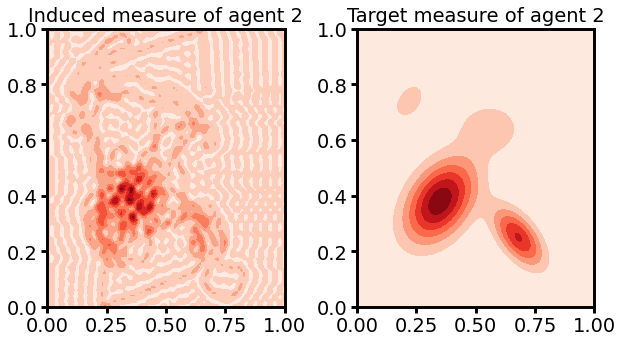

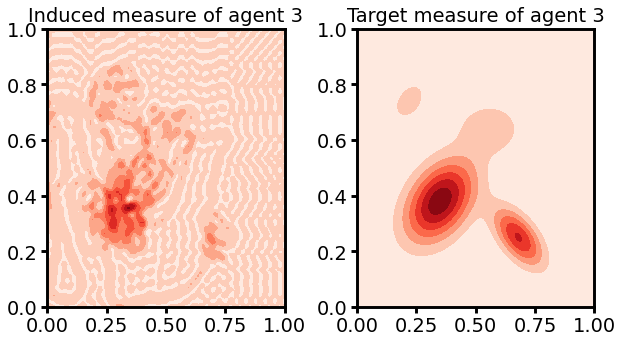

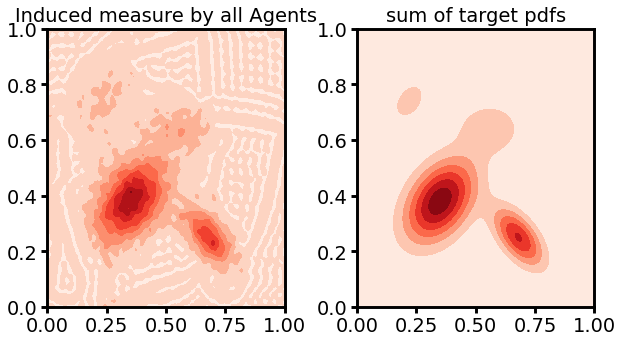

In [ ]:
all_phi = np.zeros(grids.shape[0])
all_phi_target = np.zeros(grids.shape[0])
for agent in range(N_agents):
    phi_recon = np.zeros(grids.shape[0])
    phi_recon_target = np.zeros(grids.shape[0])
    coeffs = (ck_list_update / (t * dt + dt))[:,agent]
    targets = phik_list_expanded[:,agent]
    for i, (k_vec, ck, bk, hk) in enumerate(zip(ks, coeffs, targets, hk_list)):
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
        fk_vals /= hk
        phi_recon += ck * fk_vals
        phi_recon_target += bk * fk_vals
    all_phi += phi_recon
    all_phi_target += phi_recon_target
    fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
    ax = axes[0]
    ax.set_xlim(0.0, L_list[0])
    ax.set_ylim(0.0, L_list[1])
    ax.set_title(f"Induced measure of agent {agent + 1}")
    ax.contourf(grids_x, grids_y, phi_recon.reshape(grids_x.shape), cmap='Reds')
    ax = axes[1]
    ax.set_xlim(0.0, L_list[0])
    ax.set_ylim(0.0, L_list[1])
    ax.set_title(f"Target measure of agent {agent + 1}")
    #print(phi_recon.sum(), phi_recon_target.sum())
    ax.contourf(grids_x, grids_y, phi_recon_target.reshape(grids_x.shape), cmap='Reds')
fig, axes = plt.subplots(1, 2, figsize=(9,5), dpi=70, tight_layout=True)
ax = axes[0]
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
all_phi /= N_agents
ax.set_title(f"Induced measure by all Agents")
ax.contourf(grids_x, grids_y, all_phi.reshape(grids_x.shape), cmap='Reds')
ax = axes[1]
ax.set_xlim(0.0, L_list[0])
ax.set_ylim(0.0, L_list[1])
ax.set_title(f"sum of target pdfs")
all_phi_target /= N_agents
ax.contourf(grids_x, grids_y, all_phi_target.reshape(grids_x.shape), cmap='Reds')


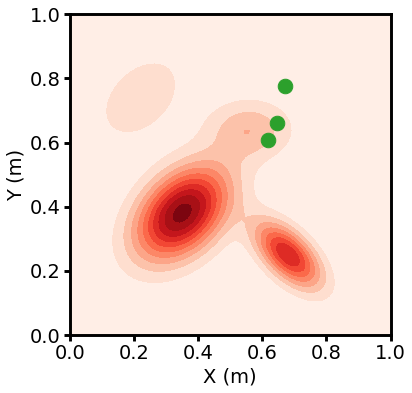

In [ ]:
# Generate animation (takes about 1 minute)
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots(1, 1, figsize=(6,7), dpi=70, tight_layout=True)
ax.set_aspect('equal')
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('X (m)')
ax.set_ylabel('Y (m)')
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), cmap='Reds', levels=10)

robot_traj, = ax.plot([], [], linestyle='-', marker='', color='k', alpha=0.2)
robot_state, = ax.plot(x_traj[0,0], x_traj[0,1], linestyle='', marker='o', markersize=15, color='C2')

def update_plot(frame):
    t = int(frame * 10)
    robot_state.set_data(
        np.array([x_traj[t][0]]), np.array([x_traj[t][1]])
    )
    robot_traj.set_data(
        x_traj[:t,0][::10], x_traj[:t,1][::10]
    )

    return robot_state, robot_traj,

#ani = animation.FuncAnimation(fig, update_plot, frames=int(tsteps/10)-1, blit=True, interval=30, repeat=False)
#video = ani.to_html5_video()
#HTML(video)